In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 기존과 동일한 전처리 및 + 형태소 분석 + 불용어 처리한 데이터를 불러오기

In [2]:
from konlpy.tag import Mecab
mecab = Mecab()
# 형태소 분석
naver['tokenized'] = naver['데이터'].apply(mecab.morphs)
steam['tokenized'] = steam['데이터'].apply(mecab.morphs)
total['tokenized'] = total['데이터'].apply(mecab.morphs)

# 불용어 지정.
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

# 불용어 제거
naver['tokenized'] = naver['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
steam['tokenized'] = steam['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
total['tokenized'] = total['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

ModuleNotFoundError: ignored

In [4]:
import pandas as pd
naver = pd.read_csv('/content/drive/MyDrive/딥러닝 공부/연구실 프로젝트 1/naver_token')
steam = pd.read_csv('/content/drive/MyDrive/딥러닝 공부/연구실 프로젝트 1/steam_token')
total = pd.read_csv('/content/drive/MyDrive/딥러닝 공부/연구실 프로젝트 1/total_token')

# 워드 임배딩
* genism Word2Vec 사용.
*

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

sentences = [row.split() for row in naver['tokenized']]
W2V_n = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

In [6]:
# dictionary 생성 후 sequence로 변환
word_to_index = {word: index for index, word in enumerate(W2V_n.wv.index_to_key)}
# 워드 임배딩 결과를 각 정수로 반환
def to_sequence(row):
    res = []
    for word in row.split():
        try:
            res.append(word_to_index[word])
        except KeyError:
            res.append(0)
    return res

naver['sequence'] = naver['tokenized'].apply(to_sequence)
max_length_n = max(naver['sequence'].apply(len))
# 길이 맞추기 및 one-hot encoding
X = pad_sequences(naver['sequence'].values, maxlen=max_length_n, padding='post')
y = to_categorical(naver['label'].values, num_classes=2)

# 분리
train_X_n, test_X_n, train_y_n, test_y_n = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 300 # 위에서 임배딩의 300으로 바궜으므로.
vocab_size = len(word_to_index)

model_n = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length_n),
  layers.GRU(units=128, dropout=0.2),
  layers.Dense(2, activation='elu')
])

early_stop1 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)
checkpoint_n = ModelCheckpoint('naver_we.h5', monitor = 'val_accuracy', mode = 'max', verbose =1, save_best_only = True)
optimizer_adamw = AdamW(weight_decay=1e-4)

model_n.compile(optimizer= optimizer_adamw, loss='categorical_crossentropy', metrics=['accuracy'])
history_naver = model_n.fit(train_X_n, train_y_n, epochs = 100, callbacks = [early_stop1, checkpoint_n], batch_size = 128, validation_split = 0.15)

Epoch 1/100
1063/1063 [==============================] - ETA: 0s - loss: 8.0583 - accuracy: 0.4999
Epoch 1: val_accuracy improved from -inf to 0.49927, saving model to naver_we.h5
1063/1063 [==============================] - 61s 50ms/step - loss: 8.0583 - accuracy: 0.4999 - val_loss: 8.0708 - val_accuracy: 0.4993
Epoch 2/100
1063/1063 [==============================] - ETA: 0s - loss: 8.0927 - accuracy: 0.4999
Epoch 2: val_accuracy did not improve from 0.49927
1063/1063 [==============================] - 12s 12ms/step - loss: 8.0927 - accuracy: 0.4999 - val_loss: 8.0708 - val_accuracy: 0.4993
Epoch 3/100
1063/1063 [==============================] - ETA: 0s - loss: 8.0749 - accuracy: 0.4999
Epoch 3: val_accuracy did not improve from 0.49927
1063/1063 [==============================] - 10s 10ms/step - loss: 8.0749 - accuracy: 0.4999 - val_loss: 8.0708 - val_accuracy: 0.4993
Epoch 4/100
1063/1063 [==============================] - ETA: 0s - loss: 8.0512 - accuracy: 0.4999
Epoch 4: val_acc

# Steam

In [8]:
sentences = [row.split() for row in steam['tokenized']]
W2V_s = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

In [26]:
# dictionary 생성 후 sequence로 변환
word_to_index = {word: index for index, word in enumerate(W2V_s.wv.index_to_key)}

# 워드 임배딩 결과를 각 정수로 반환
steam['sequence'] = steam['tokenized'].apply(to_sequence)
max_length_n = max(steam['sequence'].apply(len))
# 길이 맞추기 및 one-hot encoding
X = pad_sequences(steam['sequence'].values, maxlen=max_length_n, padding='post')
y = to_categorical(steam['label'].values, num_classes=2)

# 분리
train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X, y, test_size=0.2, random_state=42)
embedding_dim = 300 # 위에서 임배딩의 300으로 바궜으므로.
vocab_size = len(word_to_index)

model_s = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length_n),
  layers.GRU(units=128, dropout=0.2),
  layers.Dense(2, activation='elu')
])

early_stop2 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)
checkpoint_s = ModelCheckpoint('steam_we.h5', monitor = 'val_accuracy', mode = 'max', verbose =1, save_best_only = True)
optimizer_adamw = AdamW(weight_decay=1e-4)

model_s.compile(optimizer= optimizer_adamw, loss='categorical_crossentropy', metrics=['accuracy'])
history_naver = model_s.fit(train_X_s, train_y_s, epochs = 100, callbacks = [early_stop2, checkpoint_s], batch_size = 128, validation_split = 0.15)

Epoch 1/100
532/532 [==============================] - ETA: 0s - loss: 1.3310 - accuracy: 0.4981
Epoch 1: val_accuracy improved from -inf to 0.50325, saving model to steam_we.h5
532/532 [==============================] - 37s 65ms/step - loss: 1.3310 - accuracy: 0.4981 - val_loss: 0.6933 - val_accuracy: 0.5033
Epoch 2/100
532/532 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4981
Epoch 2: val_accuracy did not improve from 0.50325
532/532 [==============================] - 9s 16ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5033
Epoch 3/100
532/532 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4994
Epoch 3: val_accuracy did not improve from 0.50325
532/532 [==============================] - 7s 12ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 4/100
532/532 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4979
Epoch 4: val_accuracy did not im

# 전체

In [10]:
sentences = [row.split() for row in total['tokenized']]
W2V_t = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

In [22]:
# dictionary 생성 후 sequence로 변환
word_to_index = {word: index for index, word in enumerate(W2V_t.wv.index_to_key)}

# 워드 임배딩 결과를 각 정수로 반환
total['sequence'] = total['tokenized'].apply(to_sequence)
max_length_t = max(total['sequence'].apply(len))
# 길이 맞추기 및 one-hot encoding
X = pad_sequences(total['sequence'].values, maxlen=max_length_t, padding='post')
y = to_categorical(total['label'].values, num_classes=2)

# 분리
train_X_t, test_X_t, train_y_t, test_y_t = train_test_split(X, y, test_size=0.2, random_state=42)
embedding_dim = 300 # 위에서 임배딩의 300으로 바궜으므로.
vocab_size = len(word_to_index)

# 모델 설계
model_t = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length_t),
  layers.GRU(units=128, dropout=0.2),
  layers.Dense(2, activation='elu')
])

early_stop3 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)
checkpoint_t = ModelCheckpoint('total_we.h5', monitor = 'val_accuracy', mode = 'max', verbose =1, save_best_only = True)
optimizer_adamw = AdamW(weight_decay=1e-4)

model_t.compile(optimizer= optimizer_adamw, loss='categorical_crossentropy', metrics=['accuracy'])
history_naver = model_t.fit(train_X_t, train_y_t, epochs = 100, callbacks = [early_stop3, checkpoint_t], batch_size = 128, validation_split = 0.15)

Epoch 1/100
1594/1594 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4990
Epoch 1: val_accuracy improved from -inf to 0.49839, saving model to total_we.h5
1594/1594 [==============================] - 53s 32ms/step - loss: 0.6939 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.4984
Epoch 2/100
1594/1594 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.2469
Epoch 2: val_accuracy did not improve from 0.49839
1594/1594 [==============================] - 14s 9ms/step - loss: 0.5322 - accuracy: 0.2469 - val_loss: 0.5008 - val_accuracy: 0.2051
Epoch 3/100
1594/1594 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.1402
Epoch 3: val_accuracy did not improve from 0.49839
1594/1594 [==============================] - 14s 9ms/step - loss: 0.4130 - accuracy: 0.1402 - val_loss: 0.3955 - val_accuracy: 0.1383
Epoch 4/100
1594/1594 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.1078
Epoch 4: val_accur

In [27]:
loss_n, accuracy_n = model_n.evaluate(test_X_n, test_y_n)
loss_s, accuracy_s = model_s.evaluate(test_X_s, test_y_s)
loss_t, accuracy_t = model_t.evaluate(test_X_t, test_y_t)
print(f"Naver loss: {loss_n:.4f}, Test accuracy: {accuracy_n*100:.2f}%")
print(f"Steam loss: {loss_s:.4f}, Test accuracy: {accuracy_s*100:.2f}%")
print(f"Total loss: {loss_t:.4f}, Test accuracy: {accuracy_t*100:.2f}%")

1875/1875 [==============================] - 6s 3ms/step - loss: 0.6932 - accuracy: 0.4995
Naver loss: 1.6839, Test accuracy: 48.92%
Steam loss: 0.6341, Test accuracy: 48.18%
Total loss: 0.6932, Test accuracy: 49.95%


* 층을 더 쌓아서 진행.

In [36]:
from tensorflow.keras.layers import Dropout
# dictionary 생성 후 sequence로 변환
word_to_index = {word: index for index, word in enumerate(W2V_n.wv.index_to_key)}

# 워드 임배딩 결과를 각 정수로 반환
steam['sequence'] = steam['tokenized'].apply(to_sequence)
max_length_n = max(steam['sequence'].apply(len))
# 길이 맞추기 및 one-hot encoding
X = pad_sequences(steam['sequence'].values, maxlen=max_length_n, padding='post')
y = to_categorical(steam['label'].values, num_classes=2)

# 분리
train_X_n, test_X_n, train_y_n, test_y_n = train_test_split(X, y, test_size=0.2, random_state=42)
model_n_v2 = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length_n),
  layers.GRU(units=128, dropout=0.2),
  layers.Dense(64, activation='elu'),
  Dropout(0.4),
  layers.Dense(2, activation = 'elu')
])

early_stop1 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)
checkpoint_n = ModelCheckpoint('naver_we_v2.h5', monitor = 'val_accuracy', mode = 'max', verbose =1, save_best_only = True)
optimizer_adamw = AdamW(weight_decay=1e-4)

model_n_v2.compile(optimizer= optimizer_adamw, loss='categorical_crossentropy', metrics=['accuracy'])
history_naver = model_n_v2.fit(train_X_n, train_y_n, epochs = 100, callbacks = [early_stop1, checkpoint_n], batch_size = 128, validation_split = 0.15)

Epoch 1/100
532/532 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.4989
Epoch 1: val_accuracy improved from -inf to 0.49675, saving model to naver_we_v2.h5
532/532 [==============================] - 36s 63ms/step - loss: 0.7010 - accuracy: 0.4989 - val_loss: 0.6948 - val_accuracy: 0.4967
Epoch 2/100
532/532 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4991
Epoch 2: val_accuracy did not improve from 0.49675
532/532 [==============================] - 8s 16ms/step - loss: 0.6945 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.4966
Epoch 3/100
532/532 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4995
Epoch 3: val_accuracy did not improve from 0.49675
532/532 [==============================] - 6s 11ms/step - loss: 0.6939 - accuracy: 0.4995 - val_loss: 0.6941 - val_accuracy: 0.4967
Epoch 4/100
532/532 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5024
Epoch 4: val_accuracy improve

In [33]:
# dictionary 생성 후 sequence로 변환
word_to_index = {word: index for index, word in enumerate(W2V_s.wv.index_to_key)}

# 워드 임배딩 결과를 각 정수로 반환
steam['sequence'] = steam['tokenized'].apply(to_sequence)
max_length_s = max(steam['sequence'].apply(len))
# 길이 맞추기 및 one-hot encoding
X = pad_sequences(steam['sequence'].values, maxlen=max_length_s, padding='post')
y = to_categorical(steam['label'].values, num_classes=2)

# 분리
train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X, y, test_size=0.2, random_state=42)
model_s_v2 = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length_s),
  layers.GRU(units=128, dropout=0.2),
  layers.Dense(64, activation='elu'),
  Dropout(0.4),
  layers.Dense(2, activation = 'elu')
])

early_stop2 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)
checkpoint_s = ModelCheckpoint('steam_we_v2.h5', monitor = 'val_accuracy', mode = 'max', verbose =1, save_best_only = True)
optimizer_adamw = AdamW(weight_decay=1e-4)

model_s_v2.compile(optimizer= optimizer_adamw, loss='categorical_crossentropy', metrics=['accuracy'])
history_steam = model_s_v2.fit(train_X_s, train_y_s, epochs = 100, callbacks = [early_stop2, checkpoint_s], batch_size = 128, validation_split = 0.15)

Epoch 1/100
532/532 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.5011
Epoch 1: val_accuracy improved from -inf to 0.49675, saving model to steam_we_v2.h5
532/532 [==============================] - 37s 65ms/step - loss: 0.7037 - accuracy: 0.5011 - val_loss: 0.6935 - val_accuracy: 0.4967
Epoch 2/100
532/532 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.4999
Epoch 2: val_accuracy did not improve from 0.49675
532/532 [==============================] - 11s 20ms/step - loss: 0.6944 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4967
Epoch 3/100
532/532 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5029
Epoch 3: val_accuracy improved from 0.49675 to 0.50325, saving model to steam_we_v2.h5
532/532 [==============================] - 7s 12ms/step - loss: 0.6939 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 4/100
532/532 [==============================] - ETA: 0s - loss: 0.6937 - accuracy:

In [30]:
# dictionary 생성 후 sequence로 변환
word_to_index = {word: index for index, word in enumerate(W2V_t.wv.index_to_key)}

# 워드 임배딩 결과를 각 정수로 반환
total['sequence'] = total['tokenized'].apply(to_sequence)
max_length_t = max(total['sequence'].apply(len))
# 길이 맞추기 및 one-hot encoding
X = pad_sequences(total['sequence'].values, maxlen=max_length_t, padding='post')
y = to_categorical(total['label'].values, num_classes=2)

# 분리
train_X_t, test_X_t, train_y_t, test_y_t = train_test_split(X, y, test_size=0.2, random_state=42)
model_t_v2 = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length_t),
  layers.GRU(units=128, dropout=0.2),
  layers.Dense(64, activation='elu'),
  Dropout(0.4),
  layers.Dense(2, activation = 'elu')
])

early_stop3 = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)
checkpoint_t = ModelCheckpoint('total_we_v2.h5', monitor = 'val_accuracy', mode = 'max', verbose =1, save_best_only = True)
optimizer_adamw = AdamW(weight_decay=1e-4)

model_t_v2.compile(optimizer= optimizer_adamw, loss='categorical_crossentropy', metrics=['accuracy'])
history_steam = model_t_v2.fit(train_X_t, train_y_t, epochs = 100, callbacks = [early_stop3, checkpoint_t], batch_size = 128, validation_split = 0.15)

Epoch 1/100
1594/1594 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.50161, saving model to total_we_v2.h5
1594/1594 [==============================] - 55s 33ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 2/100
1594/1594 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.50161
1594/1594 [==============================] - 16s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 3/100
1594/1594 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.5817
Epoch 3: val_accuracy improved from 0.50161 to 0.76602, saving model to total_we_v2.h5
1594/1594 [==============================] - 15s 10ms/step - loss: 0.7209 - accuracy: 0.5817 - val_loss: 0.5849 - val_accuracy: 0.7660
Epoch 4/100
1594/1594 [==============================] - ETA: 0s - loss: 1.7

In [37]:
loss_n, accuracy_n = model_n_v2.evaluate(test_X_n, test_y_n)
loss_s, accuracy_s = model_s_v2.evaluate(test_X_s, test_y_s)
loss_t, accuracy_t = model_t_v2.evaluate(test_X_t, test_y_t)
print(f"Naver loss: {loss_n:.4f}, Test accuracy: {accuracy_n*100:.2f}%")
print(f"Steam loss: {loss_s:.4f}, Test accuracy: {accuracy_s*100:.2f}%")
print(f"Total loss: {loss_t:.4f}, Test accuracy: {accuracy_t*100:.2f}%")

1875/1875 [==============================] - 6s 3ms/step - loss: 0.6388 - accuracy: 0.8528
Naver loss: 0.6931, Test accuracy: 49.42%
Steam loss: 1.2871, Test accuracy: 74.90%
Total loss: 0.6388, Test accuracy: 85.28%


# 다른 방법 탐색.
* 허깅페이스의 kcbert를 이용해봄
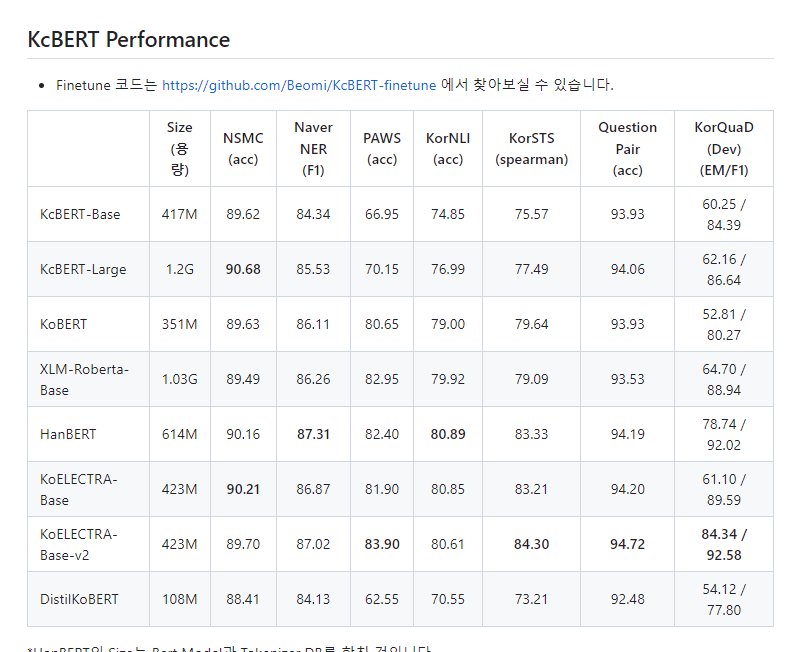